In [15]:
import matplotlib.pyplot as plt

In [16]:
def laplacian_pyramid(image, max_level=5):
        gaussian_pyramid = build_pyramid(image, max_level)
        laplacian_pyramid = []
        for i in range(len(gaussian_pyramid) - 1):
            size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
            gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size)
            laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
            laplacian_pyramid.append(laplacian)
        laplacian_pyramid.append(gaussian_pyramid[-1])
        return laplacian_pyramid

In [17]:
def build_pyramid(image, max_level=5):
        pyramid = [image]
        for _ in range(max_level):
            if image.shape[0] < 5 or image.shape[1] < 5:
                break
            image = cv2.pyrDown(image)
            pyramid.append(image)
        return pyramid

In [18]:
def reconstruct_from_pyramid(lap_pyramid):
    image = lap_pyramid[-1]
    for layer in reversed(lap_pyramid[:-1]):
        size = (layer.shape[1], layer.shape[0])
        image = cv2.pyrUp(image, dstsize=size)
        image = cv2.add(image, layer)
    return image

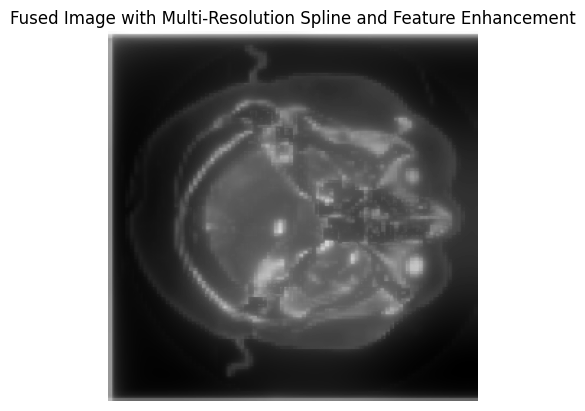

In [19]:
import cv2
import numpy as np

class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
        return resized_images

    def detect_features(self, images):
        orb = cv2.ORB_create()
        features = []
        for image in images:
            keypoints, descriptors = orb.detectAndCompute(image, None)
            features.append((keypoints, descriptors))
        return features

    def create_feature_weight_maps(self, pyramids, features, ksize=5):
        feature_weight_maps = []
        for level_features, pyramid in zip(features, pyramids):
            level_maps = []
            for i, layer in enumerate(pyramid):
                weight_map = np.zeros_like(layer, dtype=np.float32)
                for kp in level_features[0]:  # feature[0] contains keypoints
                    x, y = int(kp.pt[0] * (layer.shape[1] / pyramid[0].shape[1])), int(kp.pt[1] * (layer.shape[0] / pyramid[0].shape[0]))
                    if 0 <= x < layer.shape[1] and 0 <= y < layer.shape[0]:
                        weight_map[y, x] = 1
                weight_map = cv2.GaussianBlur(weight_map, (ksize, ksize), 0)
                level_maps.append(weight_map)
            feature_weight_maps.append(level_maps)
        return feature_weight_maps
    
    def laplacian_pyramid(image, max_level=5):
        gaussian_pyramid = build_pyramid(image, max_level)
        laplacian_pyramid = []
        for i in range(len(gaussian_pyramid) - 1):
            size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
            gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size)
            laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
            laplacian_pyramid.append(laplacian)
        laplacian_pyramid.append(gaussian_pyramid[-1])
        return laplacian_pyramid
    
    def build_pyramid(image, max_level=5):
        pyramid = [image]
        for _ in range(max_level):
            if image.shape[0] < 5 or image.shape[1] < 5:
                break
            image = cv2.pyrDown(image)
            pyramid.append(image)
        return pyramid

    def fuse(self):
        input_images = self.resize_images()
        laplacian_pyramids = [laplacian_pyramid(img, 5) for img in input_images]
        features = self.detect_features(input_images)
        feature_weight_maps = self.create_feature_weight_maps(laplacian_pyramids, features)
        
        fused_pyramid = self.fuse_pyramids_with_features(laplacian_pyramids, feature_weight_maps)
        fused_image = reconstruct_from_pyramid(fused_pyramid)
        return fused_image


    def fuse_pyramids_with_features(self, pyramids, feature_maps):
        fused_pyramid = []
        levels = len(pyramids[0])
        for level in range(levels):
            # Extract the corresponding weight map for this level from each set of feature maps
            weights = [feature_maps[i][level] + 1e-12 for i in range(len(feature_maps))]
            weight_sum = np.sum(weights, axis=0)  # Sum over the arrays, not over the list
            weights_normalized = [w / weight_sum for w in weights]
            layer_fusion = np.sum([pyr[level] * w for pyr, w in zip(pyramids, weights_normalized)], axis=0)
            fused_pyramid.append(layer_fusion)
        return fused_pyramid


# if __name__ == '__main__':
#     input_images = ['/Users/chintubharath/Documents/sdp/ct.png', '/Users/chintubharath/Documents/sdp/mri.png']
#     fusion_instance = Fusion(input_images)
#     fused_image = fusion_instance.fuse()
#     #cv2.imwrite('D:/SDP/fused_img.png', fused_image)
#     plt.imshow(fused_image, cmap='gray')
#     plt.title("Fused Image with Multi-Resolution Spline and Feature Enhancement")
#     plt.axis('off')
#     plt.show()